In [1]:
# !pip install xgboost

In [2]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

In [3]:
# nltk.download('stopwords')
# nltk.download('punkt')

### Data Cleaning

In [4]:
# function for data cleaning of tweets

# function takes as input a list of tweets and outputs a list of the cleaned version of the tweets
def dataCleaning(tweetList):
    
    # remove URLs
    tweetList1 = [re.sub(r"http\S+", "", tw) for tw in tweetList]
    
    # remove all HTML tags and replace all HTML character codes with ASCII
    tweetList1 = [tw.encode('ascii', 'ignore').decode('ascii') for tw in tweetList1]
    
    # remove retweet segment from retweets
    for i in range(len(tweetList1)):
        if tweetList1[i][:2] == 'RT':
            tweetList1[i] = tweetList1[i].split(' ', 2)[2]
            
    # remove user mentions (@)
    tweetList1 = [re.sub(r"(?:\@|https?\://)\S+", "", tw) for tw in tweetList1]
    
    # remove all numbers and other special characters
    regex = re.compile('[^a-zA-Z ]')
    tweetList1 = [regex.sub('', tw) for tw in tweetList1]
    
    # change all characters to lowercase
    tweetList1 = [tw.lower() for tw in tweetList1]
    
    # remove stop words using nltk stopwords library
    stop_words = set(stopwords.words('english'))
    for i in range(len(tweetList1)):
        example_sent = tweetList1[i]
        word_tokens = word_tokenize(example_sent)
        filtered_sentence = [w for w in word_tokens if not w in stop_words]
        filtered_sentence = []
        for w in word_tokens:
            if w not in stop_words:
                filtered_sentence.append(w)
        tweetList1[i] = ' '.join(filtered_sentence)
        
    return(tweetList1)

In [5]:
# data cleaning for sentiment_analysis

df1 = pd.read_csv('sentiment_analysis.csv')
df1 = df1.drop(columns=['ID']) # drop tweet ID

tweetList_SA = dataCleaning(df1['text'].tolist())

In [6]:
df1['clean text'] = tweetList_SA
df1[['text', 'clean text']]

,text,clean text
0,Josh Jenkins is looking forward to TAB Breeder...,josh jenkins looking forward tab breeders crow...
1,RT @MianUsmanJaved: Congratulations Pakistan o...,congratulations pakistan becoming notestteam w...
2,"RT @PEPalerts: This September, @YESmag is taki...",september taking maine mendozas surprise thank...
3,"RT @david_gaibis: Newly painted walls, thanks ...",newly painted walls thanks million custodial p...
4,RT @CedricFeschotte: Excited to announce: as o...,excited announce july feschotte lab relocating...
...,...,...
550386,@goddesses_o I can't stop watching her...mm. M...,cant stop watching hermm
550387,Poor old Tom Odell doesn't look like he would ...,poor old tom odell doesnt look like would know...
550388,#antsmasher I smashed 7 ants in this awesome ...,antsmasher smashed ants awesome gamehjfjfi
550389,@LizHudston @KymWyllie @Evasmiless @meanBok @l...,morning girls wonderful friday


In [7]:
# data cleaning for Canadian_elections_2019

df2 = pd.read_csv('Canadian_elections_2019.csv')
tweetList_elections = df2['text'].tolist()
tweetList_elections = [tw[1:] for tw in tweetList_elections]

tweetList_elections = dataCleaning(tweetList_elections)

In [8]:
df2['clean text'] = tweetList_elections
df2[['text', 'clean text']]

,text,clean text
0,"b""@RosieBarton So instead of your suggestion, ...",instead suggestion agree canadian women trust ...
1,"b""#AllWomanSpacewalk it's real!\n@Space_Statio...",allwomanspacewalk realn netobicokenorth cityof...
2,"b""#Brantford It's going to cost YOU $94 BILLIO...",brantford going cost billion next years ask ju...
3,"b""#Canada #CanadaElection2019 #CanadaVotes \n#...",canada canadaelection canadavotes nelxn nncant...
4,"b""#Canada #taxpayers are sick &amp; tired of h...",canada taxpayers sick amp tired hard earned do...
...,...,...
2128,b'You know he was doing a good enough job smea...,know good enough job smearing campaign right c...
2129,b'You missed the comment. Deflecting the issue...,missed comment deflecting issue answer best re...
2130,b'Your daily reminder:\n@theJagmeetSingh endor...,daily remindern endorses strategic votingnelxn...
2131,b'Yup...not going to reopen the abortion debat...,yupnot going reopen abortion debatexfxfxxfnelx...


### Exploratory Analysis

In [9]:
# function to determine the political party of tweets

# function takes as input a list of n tweets
# outputs a list of size n with the political party for each tweet (liberal, conservative, NDP, mutual, or none)
# if a tweet is predicted to belong to more than one political party, the value will be "mutual"
# if a tweet is predicted to have no political affiliation, the value will be "none"
# the function works by checking if a tweet contains at least one word in a list of common words for each political party
def politicalParty(tweetList):
    
    # list of common words for Liberal Party
    liberal_words = ['liberal', 'lpc', 'justin', 'trudeau']
    # list of common words for Conservative Party
    conservative_words = ['conservative', 'tory', 'tories', 'cpc', 'andrew', 'scheer', ]
    # list of common words for New Democratic Party
    ndp_words = ['new democratic party', 'ndp', 'jagmeet', 'singh']

    political_party = []

    for tw in tweetList:
        # check for affiliation with liberal party
        if any(s in tw for s in liberal_words) and not(any(s in tw for s in conservative_words)) and not(any(s in tw for s in ndp_words)):
            political_party.append('Liberal')
        # check for affiliation with conservative party
        elif not(any(s in tw for s in liberal_words)) and any(s in tw for s in conservative_words) and not(any(s in tw for s in ndp_words)):
            political_party.append('Conservative')
        # check for affiliation with new democratic party
        elif not(any(s in tw for s in liberal_words)) and not(any(s in tw for s in conservative_words)) and any(s in tw for s in ndp_words):
            political_party.append('NDP')
        # if no affiliation with any political party
        elif not(any(s in tw for s in liberal_words)) and not(any(s in tw for s in conservative_words)) and not(any(s in tw for s in ndp_words)):
            political_party.append('None')
        # if affiliated with more than one political party
        else:
            political_party.append('Mutual')
            
    return(political_party)

In [10]:
political_party_list = politicalParty(tweetList_elections)
    
political_party_df = pd.DataFrame(
    {'Clean Text': tweetList_elections, 'Political Party': political_party_list})

political_party_df

,Clean Text,Political Party
0,instead suggestion agree canadian women trust ...,Conservative
1,allwomanspacewalk realn netobicokenorth cityof...,None
2,brantford going cost billion next years ask ju...,Liberal
3,canada canadaelection canadavotes nelxn nncant...,None
4,canada taxpayers sick amp tired hard earned do...,Liberal
...,...,...
2128,know good enough job smearing campaign right c...,None
2129,missed comment deflecting issue answer best re...,None
2130,daily remindern endorses strategic votingnelxn...,Mutual
2131,yupnot going reopen abortion debatexfxfxxfnelx...,Conservative


In [11]:
# number of tweets for each political party
political_party_count = political_party_df.groupby(['Political Party']).count()['Clean Text']
political_party_count

Political Party
Conservative     438
Liberal          256
Mutual           221
NDP              121
None            1097
Name: Clean Text, dtype: int64

Q: What can you say about the distribution of the political affiliations of the tweets?

Answer:
Out of the three political parties, the Conservative Party is affiliated with the largest number of tweets, followed by the Liberal Party. The New Democratic Party is affiliated with the least amount of tweets out of the three parties.

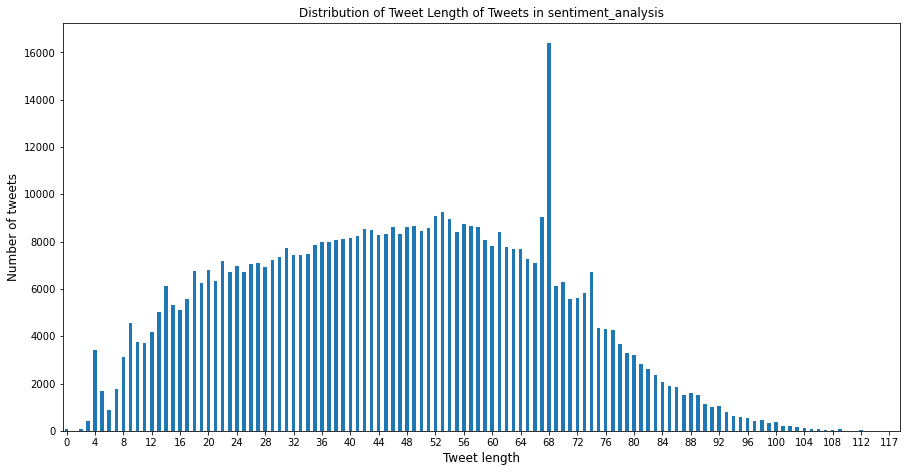

In [12]:
# bar plot of the distribution of tweet length in sentiment_analysis

df1_length = df1[['clean text']]
df1_length['tweet length'] = df1_length['clean text'].apply(len)
length_count = df1_length.groupby(['tweet length']).count().reset_index()
length_count = length_count.rename(columns={"clean text": "count"})

ax = length_count.plot.bar(x='tweet length', y='count', rot=0, figsize=(15,7.5), legend=False)
ax.set_xticks(ax.get_xticks()[::4])
plt.title('Distribution of Tweet Length of Tweets in sentiment_analysis')
plt.xlabel('Tweet length', fontsize=12)
plt.ylabel('Number of tweets', fontsize=12)
plt.show()

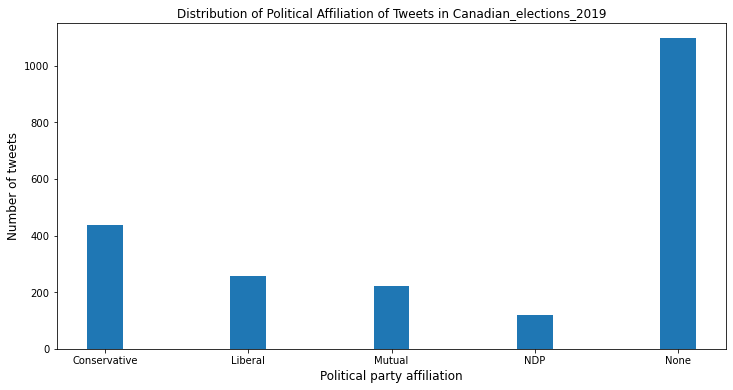

In [13]:
# bar plot of the distribution of political affiliation of tweets in Canadian_elections_2019

political_distribution = political_party_df.groupby(['Political Party']).count().reset_index()
political_distribution = political_distribution.rename(columns={"Clean Text": "count"})
x = range(5)
x_labels = political_distribution['Political Party'].tolist()
y = political_distribution['count'].tolist()

plt.figure(figsize=(12,6))
plt.bar(x, y, width=0.25)
plt.title('Distribution of Political Affiliation of Tweets in Canadian_elections_2019')
plt.xticks(x, x_labels)
plt.xlabel('Political party affiliation', fontsize=12)
plt.ylabel('Number of tweets', fontsize=12)
plt.show()

### Model Preparation

In [14]:
# function to convert tweets to bag of words features
# function takes a list of cleaned tweets as input
# function outputs the sparse matrix containing the extracted numerical features of the tweets
# max features is set to 2000 to speed up runtime
def bagOfWords(corpus):
    
    vectorizer = CountVectorizer(max_features=2000)
    X = vectorizer.fit_transform(corpus)
    
    return X

# function to convert tweets to TF-IDF features
# function takes a list of cleaned tweets as input
# function outputs the sparse matrix containing the extracted numerical features of the tweets
# max features is set to 2000 to speed up runtime
def tf_idf(corpus):
    
    vectorizer = TfidfVectorizer(max_features=2000)
    X = vectorizer.fit_transform(corpus)
    
    return X

In [15]:
# functions of classification algorithms
# all functions takes as input the training and test sets of features array and target, and outputs the model accuracy

# function for logistic regression using SKLearn
# C (inverse of regularization strength) can be set as an optional parameter
def logRegression(X_train, X_test, y_train, y_test, C=1):
    
    model = LogisticRegression(C=C)
    model.fit(X_train,y_train)
    predictions = model.predict(X_test)
    score = accuracy_score(y_test,predictions)
    
    return score

# function for k-nearest neighbors using SKLearn
# n_neighbors (number of neighbors) can be set as an optional parameter
def kNN(X_train, X_test, y_train, y_test, n_neighbors=5):
    
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(X_train,y_train)
    predictions = model.predict(X_test)
    score = accuracy_score(y_test,predictions)
    
    return score

# function for multinomial Naive Bayes using SKLearn
# multinomial option was used since it generally performs the best in NLP classification problems
# alpha (Laplace smoothing) can be set as an optional parameter
def multinomialNaiveBayes(X_train, X_test, y_train, y_test, alpha=1):
    
    model = MultinomialNB(alpha=alpha)
    model.fit(X_train,y_train)
    predictions = model.predict(X_test)
    score = accuracy_score(y_test,predictions)
    
    return score

# function for linear support-vector machine using SKLearn
# linear option was used for faster convergence
# alpha (Laplace smoothing) can be set as an optional parameter
def linearSVM(X_train, X_test, y_train, y_test, C=1):
    
    model = LinearSVC(C=C)
    model.fit(X_train,y_train)
    predictions = model.predict(X_test)
    score = accuracy_score(y_test,predictions)
    
    return score

# function for decision trees using SKLearn
# max_depth (maximum depth of tree) can be set as an optional parameter
def decisionTree(X_train, X_test, y_train, y_test, max_depth=None):
    
    model = DecisionTreeClassifier(max_depth=max_depth)
    model.fit(X_train,y_train)
    predictions = model.predict(X_test)
    score = accuracy_score(y_test,predictions)
    
    return score

# function for random forest using SKLearn
# n_estimators (number of trees) can be set as an optional parameter
def randomForest(X_train, X_test, y_train, y_test, n_estimators=10):
    
    model = RandomForestClassifier(n_estimators=n_estimators)
    model.fit(X_train,y_train)
    predictions = model.predict(X_test)
    score = accuracy_score(y_test,predictions)
    
    return score

# function for gradient boosted trees using XGBoost
# learning_rate can be set as an optional parameter
def GBT(X_train, X_test, y_train, y_test, learning_rate=0.3):
    
    model = XGBClassifier(learning_rate=learning_rate, verbosity = 0)
    model.fit(X_train,y_train)
    predictions = model.predict(X_test)
    score = accuracy_score(y_test,predictions)
    
    return score

In [16]:
# train-test split

X_SA_bagOfWords = bagOfWords(tweetList_SA)
X_SA_tf_idf = tf_idf(tweetList_SA)
y_SA = df1['label']
le = preprocessing.LabelEncoder()
le.fit(df2['sentiment'])
X_train_SA_bagOfWords, X_test_SA_bagOfWords, y_train_SA_bagOfWords, y_test_SA_bagOfWords = train_test_split(X_SA_bagOfWords, y_SA, random_state=1, test_size=0.3)
X_train_SA_tf_idf, X_test_SA_tf_idf, y_train_SA_tf_idf, y_test_SA_tf_idf = train_test_split(X_SA_tf_idf, y_SA, random_state=1, test_size=0.3)
X_elections_bagOfWords = bagOfWords(tweetList_elections)
X_elections_tf_idf = tf_idf(tweetList_elections)
y_elections_sentiment = pd.Series(le.transform(df2['sentiment']))

### Model Implementation and Tuning

In [17]:
# predicting sentiment in sentiment_analysis dataset
# models were only run once, and the resulting model accuracy was then hard-coded
# to re-run models, uncomment the code in this cell and comment out the code in the next cell

# LR_bagOfWords = logRegression(X_train_SA_bagOfWords, X_test_SA_bagOfWords, y_train_SA_bagOfWords, y_test_SA_bagOfWords)
# kNN_bagOfWords = kNN(X_train_SA_bagOfWords, X_test_SA_bagOfWords, y_train_SA_bagOfWords, y_test_SA_bagOfWords)
# NB_bagOfWords = multinomialNaiveBayes(X_train_SA_bagOfWords, X_test_SA_bagOfWords, y_train_SA_bagOfWords, y_test_SA_bagOfWords)
# SVM_bagOfWords = linearSVM(X_train_SA_bagOfWords, X_test_SA_bagOfWords, y_train_SA_bagOfWords, y_test_SA_bagOfWords)
# DT_bagOfWords = decisionTree(X_train_SA_bagOfWords, X_test_SA_bagOfWords, y_train_SA_bagOfWords, y_test_SA_bagOfWords)
# RF_bagOfWords = randomForest(X_train_SA_bagOfWords, X_test_SA_bagOfWords, y_train_SA_bagOfWords, y_test_SA_bagOfWords)
# GBT_bagOfWords = GBT(X_train_SA_bagOfWords, X_test_SA_bagOfWords, y_train_SA_bagOfWords, y_test_SA_bagOfWords)

# LR_tf_idf = logRegression(X_train_SA_tf_idf, X_test_SA_tf_idf, y_train_SA_tf_idf, y_test_SA_tf_idf)
# kNN_tf_idf = kNN(X_train_SA_tf_idf, X_test_SA_tf_idf, y_train_SA_tf_idf, y_test_SA_tf_idf)
# NB_tf_idf = multinomialNaiveBayes(X_train_SA_tf_idf, X_test_SA_tf_idf, y_train_SA_tf_idf, y_test_SA_tf_idf)
# SVM_tf_idf = linearSVM(X_train_SA_tf_idf, X_test_SA_tf_idf, y_train_SA_tf_idf, y_test_SA_tf_idf)
# DT_tf_idf = decisionTree(X_train_SA_tf_idf, X_test_SA_tf_idf, y_train_SA_tf_idf, y_test_SA_tf_idf)
# RF_tf_idf = randomForest(X_train_SA_tf_idf, X_test_SA_tf_idf, y_train_SA_tf_idf, y_test_SA_tf_idf)
# GBT_tf_idf = GBT(X_train_SA_tf_idf, X_test_SA_tf_idf, y_train_SA_tf_idf, y_test_SA_tf_idf)

In [18]:
LR_bagOfWords, LR_tf_idf = 0.9525, 0.9522
kNN_bagOfWords, kNN_tf_idf = 0.9194, 0.8478
NB_bagOfWords, NB_tf_idf = 0.9259, 0.9556
SVM_bagOfWords, SVM_tf_idf = 0.9517, 0.9523
DT_bagOfWords, DT_tf_idf = 0.9322, 0.9344
RF_bagOfWords, RF_tf_idf = 0.9435, 0.9462
GBT_bagOfWords, GBT_tf_idf = 0.9246, 0.9233

In [19]:
accuracy_array = [[LR_bagOfWords, LR_tf_idf], [kNN_bagOfWords, kNN_tf_idf], [NB_bagOfWords, NB_tf_idf],
                   [SVM_bagOfWords, SVM_tf_idf], [DT_bagOfWords, DT_tf_idf], [RF_bagOfWords, RF_tf_idf],
                  [GBT_bagOfWords, GBT_tf_idf]]

df_accuracy = pd.DataFrame(accuracy_array, columns=['Bag of words', 'TF-IDF'],
                           index=['Logistic regression', 'k-NN', 'Naive Bayes', 'SVM', 'Decision tree', 'Random forest',
                                 'Gradient-boosted trees'])
print('Accuracy of models:')
df_accuracy

Accuracy of models:


,Bag of words,TF-IDF
Logistic regression,0.9525,0.9522
k-NN,0.9194,0.8478
Naive Bayes,0.9259,0.9556
SVM,0.9517,0.9523
Decision tree,0.9322,0.9344
Random forest,0.9435,0.9462
Gradient-boosted trees,0.9246,0.9233


In [20]:
print('best model:', df_accuracy.max(axis=1).idxmax(), 'using', df_accuracy.max().idxmax(), 'features')
print('accuracy of best model:', df_accuracy.max().max()*100, '%')

best model: Naive Bayes using TF-IDF features
accuracy of best model: 95.56 %


In [21]:
# predicting sentiment in Canadian_elections_2019 dataset with best model
# multinomial Naive Bayes with TF-IDF features will be used since it had the best performance

model = MultinomialNB(alpha=1)
model.fit(X_train_SA_tf_idf, y_train_SA_tf_idf)
predictions_NB = model.predict(X_elections_tf_idf)
score_NB = accuracy_score(y_elections_sentiment,predictions_NB)

In [48]:
print('Accuracy of best model when used to predict sentiment in Canadian_elections_2019 dataset:', score_NB*100, '%')

Accuracy of best model when used to predict sentiment in Canadian_elections_2019 dataset: 51.00796999531176 %


Q: How well do your predictions match the sentiment labelled in the Canadian elections data?

Answer: The best model, multinomial Naive Bayes using TF-IDF features, only has an accuracy of 51% when used to predict sentiments in the elections dataset. This means that the model predicted the correct sentiment on just over half the tweets in the elections dataset. This same model has an accuracy of 95.25% when used to predict sentiment in sentiment_analysis dataset, meaning that there was a big drop in accuracy when the test set was switched from sentiment_analysis to the elections dataset.

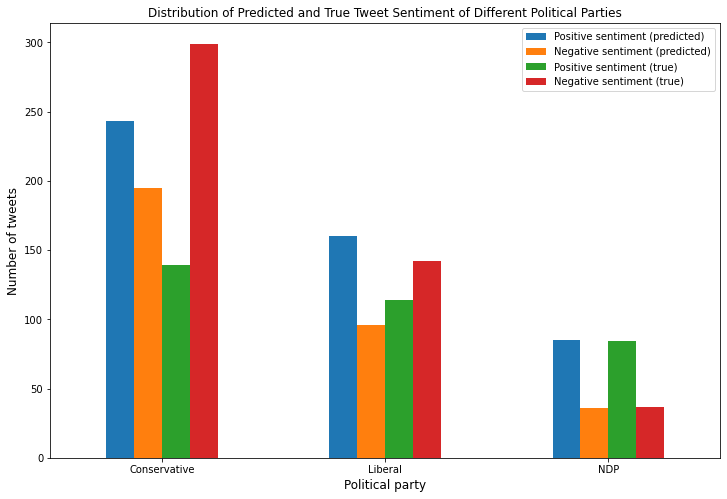

In [23]:
# plot of the distribution of true and predicted tweet sentiment for different political parties

elections_df = pd.DataFrame()
elections_df['Political Party'] = political_party_df['Political Party']
elections_df['Predicted sentiment'] = predictions_NB
elections_df['True sentiment'] = le.transform(df2['sentiment'])

conservative_df = elections_df.loc[elections_df['Political Party'] == 'Conservative']
liberal_df = elections_df.loc[elections_df['Political Party'] == 'Liberal']
ndp_df = elections_df.loc[elections_df['Political Party'] == 'NDP']
party_sentiment_df = pd.DataFrame(columns=['Positive sentiment (predicted)','Negative sentiment (predicted)','Positive sentiment (true)','Negative sentiment (true)'])
party_sentiment_df.loc['Conservative'] = [conservative_df['Predicted sentiment'].value_counts()[1],conservative_df['Predicted sentiment'].value_counts()[0],conservative_df['True sentiment'].value_counts()[1],conservative_df['True sentiment'].value_counts()[0]]
party_sentiment_df.loc['Liberal'] = [liberal_df['Predicted sentiment'].value_counts()[1],liberal_df['Predicted sentiment'].value_counts()[0],liberal_df['True sentiment'].value_counts()[1],liberal_df['True sentiment'].value_counts()[0]]
party_sentiment_df.loc['NDP'] = [ndp_df['Predicted sentiment'].value_counts()[1],ndp_df['Predicted sentiment'].value_counts()[0],ndp_df['True sentiment'].value_counts()[1],ndp_df['True sentiment'].value_counts()[0]]

ax = party_sentiment_df.plot.bar(rot=0, figsize=(12,8))
plt.title('Distribution of Predicted and True Tweet Sentiment of Different Political Parties', fontsize=12)
ax.set_xlabel("Political party", fontsize=12)
ax.set_ylabel("Number of tweets", fontsize=12)
plt.show()

Q: Discuss whether NLP analytics based on tweets is useful for political parties during election campaigns.

Answer: I believe that natural language processing is very useful for political parties during election campaigns. First of all, political parties can use NLP to predict the public's overall sentiment of their political opponents (opposing parties). From this, the political party can get a general idea of where they stand in terms of the general public (e.g. if a party's sentiment is better than the sentiment of the opposition, it means that the party is likely to win the election). Political parties can also use NLP analytics obtained from tweets to make important election campaign decisions. For example, since twitter users can be traced by the geographical location (hometown) that they set in their profile, political parties can use these analytics to determine which regions/ geographical areas have an overall negative sentiment of the party. The political party can then decide to invest more time and resources to hold additional campaigns in these regions to try and improve this sentiment. This is especially important in the "swing states" during US elections, since these states are often very hard to predict.

In [39]:
# predicting the reason for negative tweets in Canadian_elections_2019 dataset

# I chose to use 3 classification algorithms: logistic regression, multinomial Naive Bayes, and gradient-boosted trees
# I chose to use TF-IDF for the input features
# hyperparameter tuning was done with 5-fold cross validation

df2_negative = df2.assign()
df2_negative.drop(df2_negative.loc[df2_negative['sentiment']=='positive'].index, inplace=True)
list_buffer = df2_negative['text'].tolist()
list_buffer = [tw[1:] for tw in list_buffer]
list_buffer = dataCleaning(list_buffer)
X_elections_tf_idf_negative = tf_idf(list_buffer)
le2 = preprocessing.LabelEncoder()
le2.fit(df2_negative['negative_reason'])
y_elections_negative = pd.Series(le2.transform(df2_negative['negative_reason']))
X_train_elections_tf_idf_negative, X_test_elections_tf_idf_negative, y_train_elections_tf_idf_negative, y_test_elections_tf_idf_negative = train_test_split(X_elections_tf_idf_negative, y_elections_negative, random_state=2, test_size=0.3)

# hyparparameter tuning for logistic regression model
best_ACC = 0
print('logistic regression:')
for C in [0.01,0.1,1,1000,10000]:
    model = LogisticRegression(C=C)
    scores = cross_val_score(model, X_train_elections_tf_idf_negative, y_train_elections_tf_idf_negative, cv=5)
    mean_ACC = scores.mean()
    print('C =', C, ", accuracy:", round(mean_ACC*100,2), "%")
    if mean_ACC > best_ACC:
        best_C = C
        best_ACC = mean_ACC

logistic regression:
C = 0.01 , accuracy: 36.22 %
C = 0.1 , accuracy: 37.64 %
C = 1 , accuracy: 45.89 %
C = 1000 , accuracy: 51.15 %
C = 10000 , accuracy: 50.72 %


In [40]:
print('Using logistic regression:')
print('Best accuracy:', best_ACC*100, '%, optimal hyperparameter C value:', best_C)

Using logistic regression:
Best accuracy: 51.14589665653495 %, optimal hyperparameter C value: 1000


In [41]:
# hyparparameter tuning for multinomial Naive Bayes model
best_ACC = 0
print('Naive Bayes:')
for alpha in [0.0001,0.001,0.01,0.1,1]:
    model = MultinomialNB(alpha=alpha)
    scores = cross_val_score(model, X_train_elections_tf_idf_negative, y_train_elections_tf_idf_negative, cv=5)
    mean_ACC = scores.mean()
    print('alpha =', alpha, ", accuracy:", round(mean_ACC*100,2), "%")
    if mean_ACC > best_ACC:
        best_alpha = alpha
        best_ACC = mean_ACC

Naive Bayes:
alpha = 0.0001 , accuracy: 44.61 %
alpha = 0.001 , accuracy: 44.6 %
alpha = 0.01 , accuracy: 47.02 %
alpha = 0.1 , accuracy: 47.45 %
alpha = 1 , accuracy: 45.6 %


In [42]:
print('Using multinomial Naive Bayes:')
print('Best accuracy:', best_ACC*100, '%, optimal hyperparameter alpha value:', best_alpha)

Using multinomial Naive Bayes:
Best accuracy: 47.4468085106383 %, optimal hyperparameter alpha value: 0.1


In [43]:
# hyparparameter tuning for gradient-boosted trees model
best_ACC = 0
print('gradient-boosted trees:')
for lr in [0.001,0.01,0.1,0.2,0.3]:
    model = XGBClassifier(learning_rate=lr, verbosity = 0)
    scores = cross_val_score(model, X_train_elections_tf_idf_negative, y_train_elections_tf_idf_negative, cv=5)
    mean_ACC = scores.mean()
    print('learning rate =', lr, ", accuracy:", round(mean_ACC*100,2), "%")
    if mean_ACC > best_ACC:
        best_lr = lr
        best_ACC = mean_ACC

gradient-boosted trees:
learning rate = 0.001 , accuracy: 49.57 %
learning rate = 0.01 , accuracy: 52.56 %
learning rate = 0.1 , accuracy: 51.99 %
learning rate = 0.2 , accuracy: 50.14 %
learning rate = 0.3 , accuracy: 48.72 %


In [44]:
print('Using gradient-boosted trees:')
print('Best accuracy:', best_ACC*100, '%, optimal hyperparameter learning_rate value:', best_lr)

Using gradient-boosted trees:
Best accuracy: 52.556231003039514 %, optimal hyperparameter learning_rate value: 0.01


In [30]:
# X_train_elections_tf_idf_negative
# X_test_elections_tf_idf_negative
# y_train_elections_tf_idf_negative
# y_test_elections_tf_idf_negative

In [45]:
# using best model to predict negative sentiment reason of test set
# the best model is gradient-boosted trees using TF-IDF features and learning rate of 0.01

GBT_tf_idf = GBT(X_train_elections_tf_idf_negative, X_test_elections_tf_idf_negative, y_train_elections_tf_idf_negative, y_test_elections_tf_idf_negative, learning_rate=0.01)

In [46]:
print('accuracy of best model on predicting negative sentiment reason in test set:', GBT_tf_idf*100, '%')

accuracy of best model on predicting negative sentiment reason in test set: 53.64238410596026 %


### Results

Q:

Answer the research question stated above based on the outputs of your first model. Describe the results of the analysis and discuss your interpretation of the results. Explain how each party is viewed in the public eye based on the sentiment value.

Answer:

My first model, multinomial Naive Bayes using TF-IDF features, was found to be the best model for predicting the sentiment of tweets. This model was trained on the training set of the sentiment_analysis dataset. The model had an accuracy of 95.56% when tested on the test set of sentiment_analysis, which was the highest out of all the models I implemented. However, when I used this same model (trained on sentiment_analysis training set) to predict the sentiment of the Canadian_elections_2019 dataset, it was only able to achieve an accuracy of 51%. I believe that the main reason for this large drop in accuracy is most likely due to my model being slightly overfitted on the sentiment_analysis dataset.

From the bar plot "Distribution of Predicted and True Tweet Sentiment of Different Political Parties", it can be seen that the true sentiment of both the Conservative Party and Liberal Party seems to be mostly negative. In contrast, the true sentiment of the New Democratic Party is mostly positive. My model, however, predicted all three political parties to have more positive sentiment than negative sentiment. The true sentiment of the political parties tells us that in the public has mainly negative views on the Conservative Party and the Liberal Party, and has mainly positive views for the New Democratic Party.

Q:

For the second model, based on the model that worked best, provide a few reasons why your model may fail to predict the correct negative reasons. Back up your reasoning with examples from the test sets.

Answer:

My second model, gradient boosted trees using TF-IDF features with a 0.01 learning rate, was found to be the best model for predicting the reason for negative tweets in the elections dataset. When used on the test set, this model had an accuracy of 53.64%. I believe that there are two main reasons as to why my model may have failed to correctly predict some of the negative reasons of the tweets. The first reason is that some of the negative reasons are very similar to each other. For example, "scandal" and "tell lies" are very similar to each other, which means that tweets under these two reasons most likely share a lot of key words. To back up my claim, if we look at the test set, we can see that tweet 22 is classified as "scandal" and tweet 105 is classified as "tell lies", however both of these tweets have the word "disinformation" in them. These similarities amongst different target classes may have introduced unnecessary bias into the classification model.

The second reason is the presence of the "Others" category in the target class (negative reasons). This category is not a single negative reason, but is actually all of the reasons not listed combined into one. Furthermore, if we look at the test set, this "others" category is by far the biggest target class out of all of the negative reasons, with a total of 365 tweets in this category. In terms of natural language processing, this can impact the performance of the classification model by introducing unnecessary variance into the data, since tweets in this class will most likely have a very wide variety of different words amongst them.

Q:

For both models, suggest one way you can improve the accuracy of your models.

Answer:

One way that I can improve my first model (predicting sentiment) is to account for the order of the words in the tweets. Having the machine learning model learn the syntactic information of the tweets will most definitely improve accuracy. A common way to do this is to treat each tweet as a sequence of individual word vectors and train it through a convolutional neural network.

A way to improve my second model (predicting negative sentiment reason) would be to increase the maximum features of my TF-IDF vectorizer. Having more features means that the machine learning model will be able to train using a wider variety of words, which will most likely improve the accuracy of the model. Different classes having similar words between each other will not be as big of an issue anymore if number of features are increased, since there are more words for the model to train on.